<div style="border: 2px solid blue; padding: 5px; color: red; text-align: center; font-size: 24px;">
 Self-attention  vs Multi-head Attention
</div>

Le but de ce notebook est de comparer des embeddings calcués avec des couches de self-attention et multi-head attention.



# Librairies

In [1]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_style('darkgrid')

In [2]:
batch_size = 32

# Data

Nous allons utiliser un jeu de données disponible.

In [15]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/opt/anaconda3/envs/vader/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
emotions["train"]["text"]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [6]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create dataset and dataloader
train_dataset = TextDataset(emotions["train"]["text"], emotions["train"]["label"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TextDataset(emotions["validation"]["text"], emotions["validation"]["label"], tokenizer)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TextDataset(emotions["test"]["text"], emotions["test"]["label"], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
for i in train_loader:
    print(i)
    break

{'text': ['i feel accepted welcomed', 'i feel is hostile kinship or mounting nausea did you know that back means the binding itself', 'i feel so heartless sometimes because i do not have the ability to mourn for the lost of someone relating to my past grandparents', 'i dance the more i feel joy the more generous i become with myself the more i live in the present the more i let myself off the trauma hook the less important the past becomes', 'im lying in bed writing this feeling exceptionally smug about the fact ive got two more days off cos ive got lots of lovely plans', 'i dont know if i cans trust him and i dont know how he feels about trusting me', 'i am feeling very gorgeous and i dont have to go outside in the cold with a bald head or with a wig that i dont like all that much', 'when i ate a rotten apple', 'i feel relaxed and can just enjoy it', 'i was going crazy thank god i have a craving for fruits and chocolate it made me go out in the cold with a gross wind blowing in my nec

# Modèles


Pour le self-attention, nous implémentons les étapes suivantes:
1. Les poids d'attention sont donnés par: $\hat{a} = q * k_i$, puis ils ont normalisés avec le softmax : $a_i =\frac{e^{\hat{a}_{i}}}{\sum_{j}{e^{\hat{a}_{j}}}} $
2. La sortie (output z) $z$ est le produit entre les poids d'attention $a_{1:N}$ et les valeurs $V_{1:N}$
    $$ {\color{blue} z = } \sum_{i}{\hat{a}_i*{\color{red}v_i}} = \hat{a}*{\color{red}v}$$
3. k , v sont calculés à partir de l'input x :
    $${\color{green}k} = {\color{green}W_k}*{\color{blue}x}$$
    $${\color{green}v} = {\color{green}W_v}*{\color{blue}x}$$
4. Les queries : $${\color{green}q} = {\color{green}W_q}*{\color{blue}x}$$

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x, attention_mask):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / (self.embed_size ** 0.5)
        # attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=attention_scores.dtype)
        # attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention = self.softmax(attention_scores)
        out = torch.bmm(attention, V)
        return out

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by num_heads"

        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)
        self.softmax = nn.Softmax(dim=3)

    def forward(self, x, attention_mask):
        N = x.shape[0]
        Q = self.query(x).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        attention_scores = torch.matmul(Q, K.transpose(2, 3)) / (self.head_dim ** 0.5)
        # attention_scores = attention_scores.masked_fill(attention_mask == 0, float('-inf'))
        attention = self.softmax(attention_scores)
        out = torch.matmul(attention, V).transpose(1, 2).contiguous().view(N, -1, self.embed_size)
        out = self.fc_out(out)
        return out

Nous allons entrainer un text classifier avec un réseau à trois couches:
1. Une couche d'embedding
2. Une couche d'attention (self-attention ou multi-head attention)
3. Une couche linéaire

In [10]:
class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size, n_labels):
        super(SelfAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = SelfAttention(embed_size)
        self.fc = nn.Linear(embed_size, n_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.attention(x, attention_mask)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

class MultiHeadAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, n_labels):
        super(MultiHeadAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.fc = nn.Linear(embed_size, n_labels)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.attention(x, attention_mask)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [91]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self,  model):
        '''Saves model when validation loss decreases.'''
        torch.save(model.state_dict(), self.path)

In [95]:
def train_model(model, train_loader, val_loader, epochs=5, patience=5, min_delta=10e-4, path='best_model.pth'):
    print("Training model for {} epochs".format(epochs))
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, path=path)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    all_losses = []
    valid_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            # Convert texts to tensor of token indices
            outputs = model(data['input_ids'], data['attention_mask'])
            loss = criterion(outputs, data['label'])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        all_losses.append(train_loss/len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                outputs = model(data['input_ids'], data['attention_mask'])
                loss = criterion(outputs, data['label'])
                val_loss += loss.item()
        valid_losses.append(val_loss/len(val_loader))
        early_stopping(val_loss, model)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}, Train loss: {train_loss/len(train_loader)}")
    return all_losses, valid_losses

In [94]:
# Initialisons les modèles
n_labels = len(np.unique(emotions['train']['label']))
vocab_size = tokenizer.vocab_size
embed_size = 128
num_heads = 8
epochs = 20
self_attention_model = SelfAttentionModel(vocab_size, embed_size, n_labels=n_labels)
multi_head_attention_model = MultiHeadAttentionModel(vocab_size, embed_size, num_heads, n_labels=n_labels)


In [96]:
print("Training Self-Attention Model")
train_loss_self_attention, valid_loss_self_attention = train_model(self_attention_model, train_loader, valid_loader, epochs=epochs,path='best_self_attention_model.pth')



Training Self-Attention Model
Training model for 20 epochs
Epoch 1, Validation Loss: 1.5719418601384239, Train loss: 1.5827256259918212
Epoch 2, Validation Loss: 1.2790911632870872, Train loss: 1.441307097196579
Epoch 3, Validation Loss: 1.004105334244077, Train loss: 1.1002371113300324
Epoch 4, Validation Loss: 0.8893903711485485, Train loss: 0.8217018039822579
Epoch 5, Validation Loss: 0.8189563606939618, Train loss: 0.6396652698218822
Epoch 6, Validation Loss: 0.7793018340118347, Train loss: 0.5137566925883293
Epoch 7, Validation Loss: 0.750631812309462, Train loss: 0.4288475688248873
Epoch 8, Validation Loss: 0.7718659904268053, Train loss: 0.3679833513945341
Epoch 9, Validation Loss: 0.7611512544136199, Train loss: 0.30717339883744715
Epoch 10, Validation Loss: 0.830068810591622, Train loss: 0.26800575095415113
Epoch 11, Validation Loss: 0.8131597905404984, Train loss: 0.22908759550750254
Epoch 12, Validation Loss: 0.8054488850018334, Train loss: 0.1941571821756661
Epoch 13, Valid

Text(0.5, 1.0, 'Self-Attention Model')

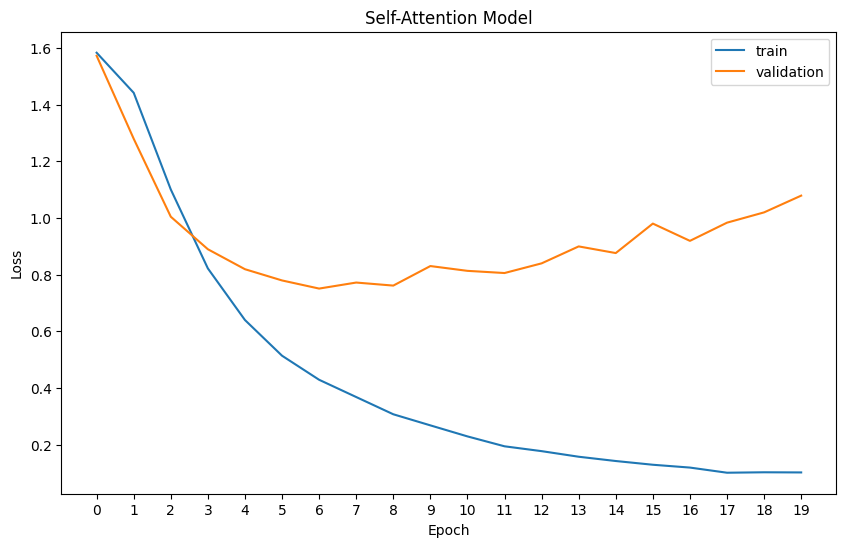

In [97]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(epochs), y=train_loss_self_attention, label='train')
sns.lineplot(x=range(epochs), y=valid_loss_self_attention, label='validation')
# set xaixs with only epochs values
plt.xticks(range(epochs))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Self-Attention Model')

In [98]:
print("Training Multi-Head Attention Model")
train_loss_multi_head, valid_loss_multi_head = train_model(multi_head_attention_model, train_loader, valid_loader, epochs=epochs,path='best_multihead_attention_model.pth')

Training Multi-Head Attention Model
Training model for 20 epochs
Epoch 1, Validation Loss: 0.7099913415454683, Train loss: 1.139458918571472
Epoch 2, Validation Loss: 0.4156156482677611, Train loss: 0.47489393077790737
Epoch 3, Validation Loss: 0.4007693160147894, Train loss: 0.2817511390708387
Epoch 4, Validation Loss: 0.4136170811123318, Train loss: 0.20260930359363555
Epoch 5, Validation Loss: 0.48852553656176917, Train loss: 0.15558856381103398
Epoch 6, Validation Loss: 0.5318494067778663, Train loss: 0.11103424381650984
Epoch 7, Validation Loss: 0.568115140887953, Train loss: 0.09892438277462498
Epoch 8, Validation Loss: 0.653346622628825, Train loss: 0.07481084904493764
Epoch 9, Validation Loss: 0.7066069992761763, Train loss: 0.06354604937788098
Epoch 10, Validation Loss: 0.7117220409258845, Train loss: 0.059686847935430706
Epoch 11, Validation Loss: 0.740397167406858, Train loss: 0.05258976417139638
Epoch 12, Validation Loss: 0.7112446811700625, Train loss: 0.04620624803740066


Text(0.5, 1.0, 'Multi head Attention Model')

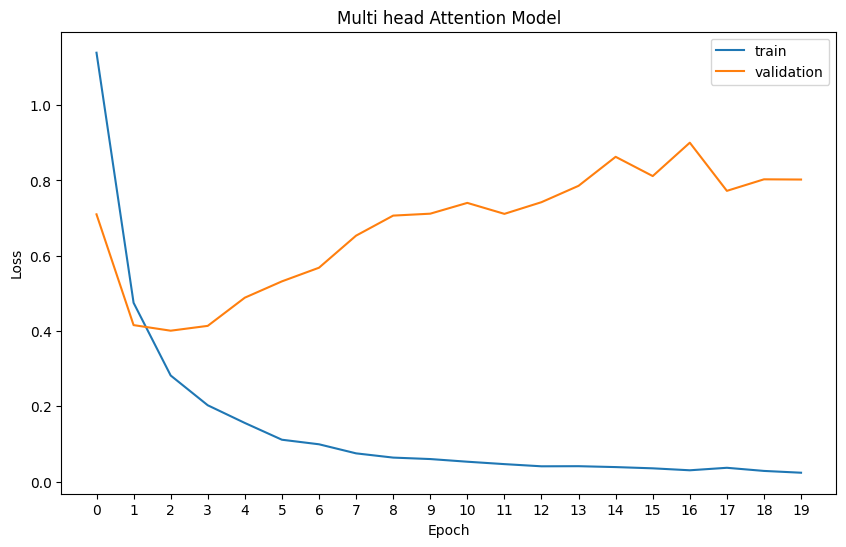

In [99]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(epochs), y=train_loss_multi_head, label='train')
sns.lineplot(x=range(epochs), y=valid_loss_multi_head, label='validation')
# set xaixs with only epochs values
plt.xticks(range(epochs))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi head Attention Model')

# Evaluation and Explicabilité

In [107]:
self_attention_model.load_state_dict(torch.load('best_self_attention_model.pth'))
multi_head_attention_model.load_state_dict(torch.load('best_multihead_attention_model.pth'))

/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_3516/4104137105.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self_attention_model.load_state_dict(torch.loa

<All keys matched successfully>

In [108]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, title):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title(f"Normalized confusion matrix for {title} model")
    plt.show()

def compute_pred(model, data):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for data in data:
            outputs = model(data['input_ids'], data['attention_mask'])
            preds.extend(outputs.argmax(dim=1).tolist())
            true.extend(data['label'].tolist())
    return preds, true
    

In [109]:
labels = emotions["train"].features["label"].names

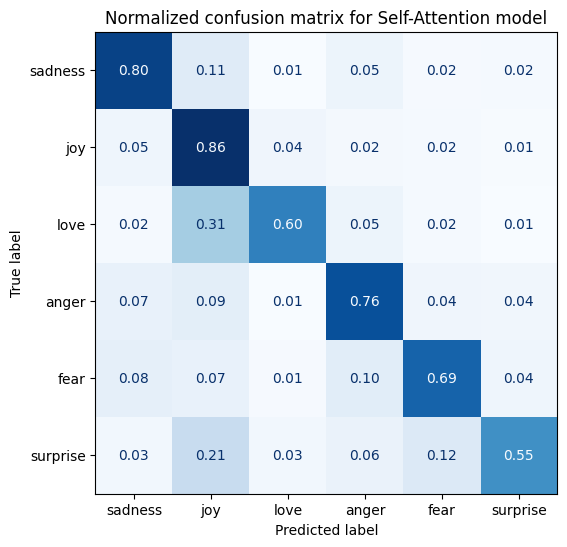

In [122]:
preds_self, true_self = compute_pred(self_attention_model, test_loader)
plot_confusion_matrix(preds_self, true_self, labels, "Self-Attention")

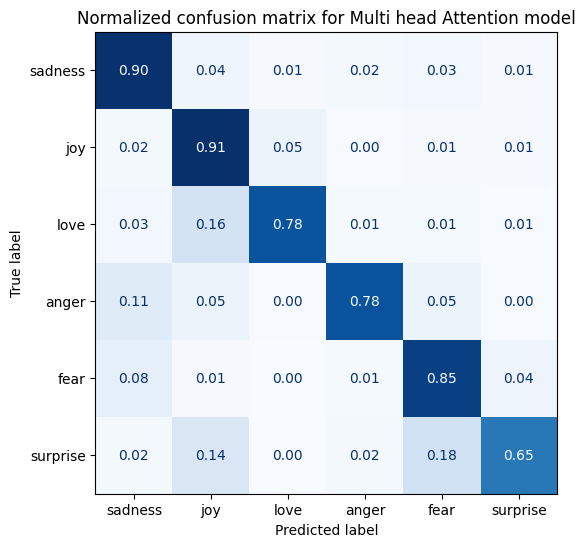

In [123]:
preds, true = compute_pred(multi_head_attention_model, test_loader)
plot_confusion_matrix(preds, true, labels, "Multi head Attention")

In [117]:
self_cf = classification_report(true_self, preds_self, target_names=labels, output_dict=True)
self_cf = pd.DataFrame(self_cf).T
self_cf

,precision,recall,f1-score,support
sadness,0.862454,0.798623,0.829312,581.0000
joy,0.781984,0.861871,0.819986,695.0000
love,0.703704,0.597484,0.646259,159.0000
anger,0.724739,0.756364,0.740214,275.0000
fear,0.778894,0.691964,0.732861,224.0000
surprise,0.480000,0.545455,0.510638,66.0000
accuracy,0.778500,0.778500,0.778500,0.7785
macro avg,0.721962,0.708627,0.713212,2000.0000
weighted avg,0.780955,0.778500,0.777949,2000.0000


In [118]:
mh_cf = classification_report(true, preds, target_names=labels, output_dict=True)
mh_cf = pd.DataFrame(mh_cf).T
mh_cf

,precision,recall,f1-score,support
sadness,0.884550,0.896730,0.890598,581.000
joy,0.894737,0.905036,0.899857,695.000
love,0.738095,0.779874,0.758410,159.000
anger,0.918803,0.781818,0.844794,275.000
fear,0.791667,0.848214,0.818966,224.000
surprise,0.651515,0.651515,0.651515,66.000
accuracy,0.861000,0.861000,0.861000,0.861
macro avg,0.813228,0.810531,0.810690,2000.000
weighted avg,0.863064,0.861000,0.861096,2000.000


/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_3516/1980805321.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["precision"].iloc[:6][i], mh_cf["precision"].iloc[:6][i]))


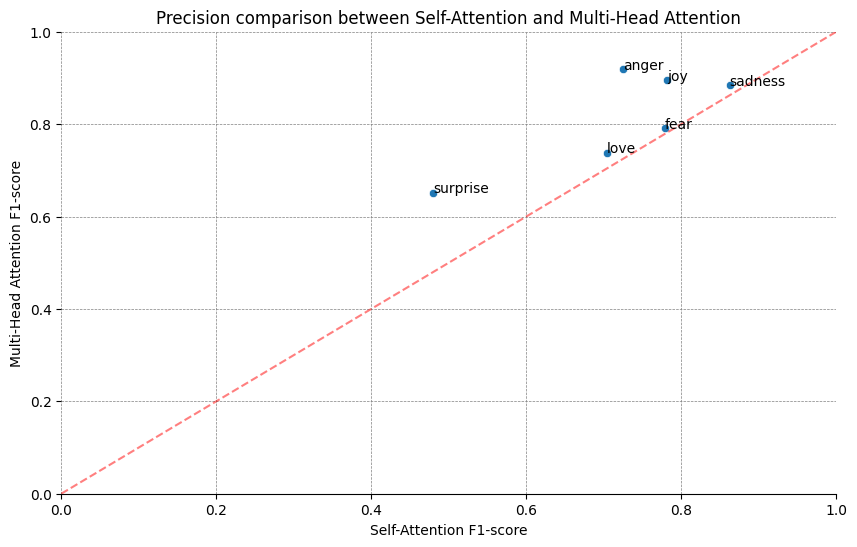

In [125]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=self_cf.iloc[:6]["precision"], y=mh_cf.iloc[:6]["precision"])
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["precision"].iloc[:6][i], mh_cf["precision"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Self-Attention F1-score")
plt.ylabel("Multi-Head Attention F1-score")
plt.title("Precision comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_3516/3226506339.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["recall"].iloc[:6][i], mh_cf["recall"].iloc[:6][i]))


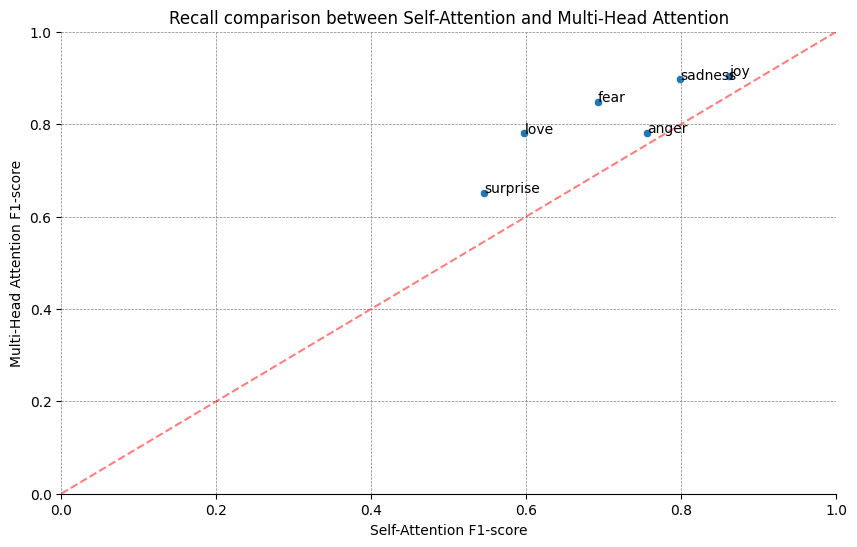

In [126]:
plt.figure(figsize=(10, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
sns.scatterplot(x=self_cf.iloc[:6]["recall"], y=mh_cf.iloc[:6]["recall"])
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["recall"].iloc[:6][i], mh_cf["recall"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#set all axis min to 0 and max to 1

plt.xlabel("Self-Attention F1-score")
plt.ylabel("Multi-Head Attention F1-score")
plt.title("Recall comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

/var/folders/6d/dll_cr11353f0zcrbycxldth0000gn/T/ipykernel_3516/3167453432.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (self_cf["f1-score"].iloc[:6][i], mh_cf["f1-score"].iloc[:6][i]))


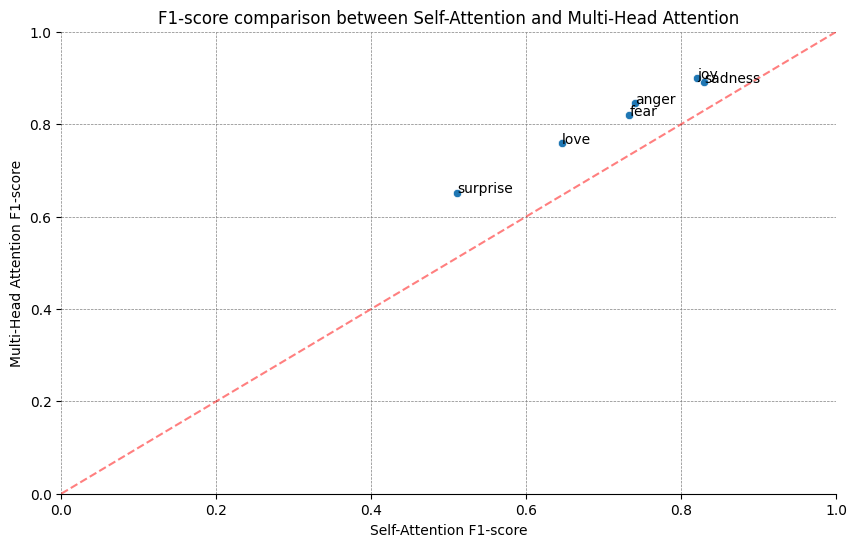

In [127]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=self_cf.iloc[:6]["f1-score"], y=mh_cf.iloc[:6]["f1-score"])
plt.xlim(0, 1)
plt.ylim(0, 1)
# add index name as label in the plot
for i, txt in enumerate(labels):
    plt.annotate(txt, (self_cf["f1-score"].iloc[:6][i], mh_cf["f1-score"].iloc[:6][i]))
# add the diagonal line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c="red", alpha=0.5)
# removre superior line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xlabel("Self-Attention F1-score")
plt.ylabel("Multi-Head Attention F1-score")
plt.title("F1-score comparison between Self-Attention and Multi-Head Attention")
# add dark grid mode
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

Le modèle avec plusieurs têtes d'attention a un meilleure score de F1.